# Data Exploration & Preparation

This notebook is used to explore the in-situ data for the entire list of STEREO A and B ICMEs.

Parameters of interest:
- Magnetic field components
- Magnetic field strength
- Proton number density
- Proton speed
- Proton temperature

In [1]:
from collections import defaultdict
import datetime as dt
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
from pyts.image import RecurrencePlot

from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[dt.date] = converter
munits.registry[dt.datetime] = converter

### Parse the full helcats ICME list and extract all of the stereo A and B ICMEs

In [2]:
with open('../ICME_WP4_V10.json', 'r') as fobj:
    json_data = json.load(fobj)
    
df = pd.DataFrame(json_data['data'], columns=json_data['columns'])

sta_icme_df = df[df['SC_INSITU'].str.contains('STEREO-A')]
stb_icme_df = df[df['SC_INSITU'].str.contains('STEREO-B')]

sta_icme_df.index = pd.DatetimeIndex(sta_icme_df.loc[:,'ICME_START_TIME']).tz_localize(None)
stb_icme_df.index = pd.DatetimeIndex(stb_icme_df.loc[:,'ICME_START_TIME']).tz_localize(None)

In [76]:
sta_icme_df.to_csv('../data/sta_icme_list.txt', header=True, index=True)
stb_icme_df.to_csv('../data/stb_icme_list.txt', header=True, index=True)

In [48]:
def read_stereo_datasets(fname):
    """Function for reading in stereo datasets"""
    with open(fname, 'r') as fobj:
        lines = fobj.readlines()

    colnames = lines[0].split()
    tmp = lines[1].split()
    units = []
    units.append(' '.join(tmp[:2]))
    units += tmp[2:]

    for col, unit in zip(colnames, units):
        print(col, unit)
        
    data = []
    index = []
    for line in tqdm(lines[2:]):
        lsplit = line.split()
        index.append(dt.datetime.strptime(' '.join(lsplit[:2]), '%d-%m-%Y %H:%M:%S.%f'))
        data.append(list(map(float, lsplit[2:])))
    
    df = pd.DataFrame(data, columns=colnames[1:], index=pd.DatetimeIndex(index))
    return df

### STEREO A dataset

In [49]:
sta_icme_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2007-01-14 12:11:00 to 2014-08-11 09:03:00
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ICMECAT_ID              168 non-null    object
 1   SC_INSITU               168 non-null    object
 2   ICME_START_TIME         168 non-null    object
 3   MO_START_TIME           168 non-null    object
 4   MO_END_TIME             168 non-null    object
 5   ICME_END_TIME           168 non-null    object
 6   MO_BMAX                 168 non-null    object
 7   MO_BMEAN                168 non-null    object
 8   MO_BSTD                 168 non-null    object
 9   MO_BZMEAN               168 non-null    object
 10  MO_BZMIN                168 non-null    object
 11  MO_DURATION             168 non-null    object
 12  SC_HELIODISTANCE        168 non-null    object
 13  SC_LONG_HEEQ            168 non-null    object
 14  SC_LAT_HEEQ          

In [50]:
sta_data_df = read_stereo_datasets('../data/sta_l2_magplasma.txt')

EPOCH dd-mm-yyyy hh:mm:ss.ms
BTOTAL nT
R_RTN AU
NP 1/cm3
SPEED km/s
TEMPERATURE deg_K
THERMAL_SPEED km/s
VP_RTN km/sec
BETA Na
TOTAL_PRESSURE pPa
MAGNETIC_PRESSURE pPa
DYNANMIC_PRESSURE nPa
BX(RTN) nT
BY(RTN) nT
BZ(RTN) nT


In [51]:
sta_data_df.index[0]

Timestamp('2007-01-01 00:00:00')

<AxesSubplot:>

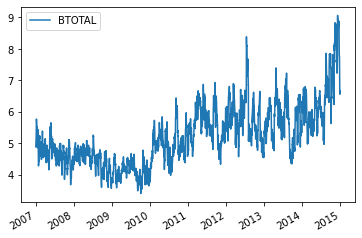

In [52]:
sta_data_df[sta_data_df['BTOTAL'].gt(-1e30)].sort_index().rolling('20D', center=True).mean().plot(y='BTOTAL')

In [53]:
for col in sta_data_df.columns:
    print(col)

BTOTAL
R_RTN
NP
SPEED
TEMPERATURE
THERMAL_SPEED
VP_RTN
BETA
TOTAL_PRESSURE
MAGNETIC_PRESSURE
DYNANMIC_PRESSURE
BX(RTN)
BY(RTN)
BZ(RTN)


In [59]:
cols_of_interest = [
    'BTOTAL', 
    'BX(RTN)',
    'BY(RTN)',
    'BZ(RTN)', 
    'VP_RTN',
    'NP',
    'TEMPERATURE',
    'BETA'
]

In [60]:
sta_data_cut_df = sta_data_df[cols_of_interest]

In [61]:
sta_data_cut_df = sta_data_cut_df[sta_data_cut_df.gt(-1e30)].dropna().sort_index()

Remove all rows where the number density, temperature, or beta values are negative since they are unphysical

In [62]:
sta_data_cut_df = sta_data_cut_df[~sta_data_cut_df['NP'].lt(0)]
sta_data_cut_df = sta_data_cut_df[~sta_data_cut_df['TEMPERATURE'].lt(0)]
sta_data_cut_df = sta_data_cut_df[~sta_data_cut_df['BETA'].lt(0)]

In [63]:
sta_data_cut_df.describe()

,BTOTAL,BX(RTN),BY(RTN),BZ(RTN),VP_RTN,NP,TEMPERATURE,BETA
count,3.543276e+06,3.543276e+06,3.543276e+06,3.543276e+06,3.543276e+06,3.543276e+06,3.543276e+06,3.543276e+06
mean,5.069539e+00,-1.408620e-01,1.139330e-01,-7.498644e-03,4.049416e+02,5.267301e+00,7.347075e+04,2.617007e+00
std,2.661191e+00,3.119996e+00,3.646524e+00,2.996122e+00,9.609274e+01,4.843194e+00,7.054722e+04,8.597773e+00
min,1.348080e-01,-2.881470e+01,-4.106490e+01,-3.958670e+01,2.334080e+02,1.416540e-02,5.541540e+02,4.649130e-03
25%,3.433730e+00,-2.407550e+00,-2.313270e+00,-1.536280e+00,3.327240e+02,2.465747e+00,3.255028e+04,8.266545e-01
50%,4.442240e+00,-1.544590e-01,1.489060e-01,-1.573185e-02,3.831290e+02,3.868510e+00,5.303050e+04,1.397120e+00
75%,5.950880e+00,2.204580e+00,2.523592e+00,1.541770e+00,4.584470e+02,6.349015e+00,9.103032e+04,2.460643e+00
max,4.920680e+01,2.935560e+01,3.978210e+01,4.463500e+01,8.409310e+02,1.122680e+02,5.249400e+06,2.648700e+03


In [64]:
(~sta_data_cut_df['NP'].lt(0)).sum()

3543276

In [65]:
sta_data_cut_df.to_csv("sta_dataset_cleaned.txt", header=True, index=True)

In [66]:
sta_data_cut_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3543276 entries, 2007-02-14 00:02:00 to 2014-08-18 23:58:00
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   BTOTAL       float64
 1   BX(RTN)      float64
 2   BY(RTN)      float64
 3   BZ(RTN)      float64
 4   VP_RTN       float64
 5   NP           float64
 6   TEMPERATURE  float64
 7   BETA         float64
dtypes: float64(8)
memory usage: 243.3 MB


In [67]:
cols_of_interest

['BTOTAL',
 'BX(RTN)',
 'BY(RTN)',
 'BZ(RTN)',
 'VP_RTN',
 'NP',
 'TEMPERATURE',
 'BETA']

In [68]:
def quality_check_plot(stereo_df, icme_date, window_size=dt.timedelta(days=5), cols=[], normalize=True):
    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(5,10), gridspec_kw={'hspace':0.1}, sharex=True)
    icme_window = slice(icme_date - window_size, icme_date + window_size)
    icme_data = stereo_df[icme_window][cols]
    for col, ax in zip(cols, axes):
        x = icme_data.index
        if normalize:
            y = StandardScaler().fit_transform(icme_data[col].values.reshape(-1,1)).flatten()
        else:
            y = icme_data[col]
        ax.plot(x, y, lw=0.8)
        ax.set_ylabel(col)
#         mean, std = icme_data[col].mean(), icme_data[col].std()
#         if 'temp' in col.lower() and not normalize:
#             ax.set_yscale('log')
        ax.grid(True, lw=0.8, ls='--', alpha=0.5, c='k')
        ax.axvline(icme_date, ls='-', c='r', lw=1.25)
    axes[0].set_title(f'Normalized ICME Measurements\n ICME Start time: {icme_date}')
    return fig

In [69]:
sta_icme_df.head()

,ICMECAT_ID,SC_INSITU,ICME_START_TIME,MO_START_TIME,MO_END_TIME,ICME_END_TIME,MO_BMAX,MO_BMEAN,MO_BSTD,MO_BZMEAN,...,MO_SPEED,MO_SPEED_STD,SHEATH_DENSITY,SHEATH_DENSITY_STD,MO_DENSITY,MO_DENSITY_STD,SHEATH_TEMPERATURE,SHEATH_TEMPERATURE_STD,MO_TEMPERATURE,MO_TEMPERATURE_STD
ICME_START_TIME,,,,,,,,,,,,,,,,,,,,,
2007-01-14 12:11:00,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14T12:11Z,2007-01-14T14:39Z,2007-01-15T07:34Z,9999-99-99T99:99Z,14.9,12.4,1.8,1.0,...,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN
2007-05-22 14:00:00,ICME_STEREO_A_JIAN_20070522_01,STEREO-A,2007-05-22T14:00Z,2007-05-22T14:00Z,2007-05-23T13:30Z,9999-99-99T99:99Z,11.8,9.6,1.6,-4.4,...,498.5,18.4,NaN,NaN,4.4,2.9,NaN,NaN,42323.5,23120.6
2007-08-25 20:30:00,ICME_STEREO_A_JIAN_20070825_01,STEREO-A,2007-08-25T20:30Z,2007-08-25T23:27Z,2007-08-26T16:00Z,9999-99-99T99:99Z,14.7,13.0,0.9,-3.7,...,350.2,10.2,39.6,6.0,12.7,4.4,46029.4,12501.6,55856.6,30342.4
2007-11-19 22:00:00,ICME_STEREO_A_JIAN_20071119_01,STEREO-A,2007-11-19T22:00Z,2007-11-19T22:00Z,2007-11-21T03:17Z,9999-99-99T99:99Z,19.3,9.9,3.0,0.2,...,419.4,9.9,NaN,NaN,10.2,8.7,NaN,NaN,36033.6,16108.6
2008-03-21 06:40:00,ICME_STEREO_A_JIAN_20080321_01,STEREO-A,2008-03-21T06:40Z,2008-03-21T08:33Z,2008-03-21T18:39Z,9999-99-99T99:99Z,8.8,8.1,0.4,-3.2,...,446.9,9.1,8.9,2.5,1.2,1.4,35758.7,8607.1,47544.2,21392.9


In [73]:
sta_icme_df.head()

,ICMECAT_ID,SC_INSITU,ICME_START_TIME,MO_START_TIME,MO_END_TIME,ICME_END_TIME,MO_BMAX,MO_BMEAN,MO_BSTD,MO_BZMEAN,...,MO_SPEED,MO_SPEED_STD,SHEATH_DENSITY,SHEATH_DENSITY_STD,MO_DENSITY,MO_DENSITY_STD,SHEATH_TEMPERATURE,SHEATH_TEMPERATURE_STD,MO_TEMPERATURE,MO_TEMPERATURE_STD
ICME_START_TIME,,,,,,,,,,,,,,,,,,,,,
2007-01-14 12:11:00,ICME_STEREO_A_JIAN_20070114_01,STEREO-A,2007-01-14T12:11Z,2007-01-14T14:39Z,2007-01-15T07:34Z,9999-99-99T99:99Z,14.9,12.4,1.8,1.0,...,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN,-NaN
2007-05-22 14:00:00,ICME_STEREO_A_JIAN_20070522_01,STEREO-A,2007-05-22T14:00Z,2007-05-22T14:00Z,2007-05-23T13:30Z,9999-99-99T99:99Z,11.8,9.6,1.6,-4.4,...,498.5,18.4,NaN,NaN,4.4,2.9,NaN,NaN,42323.5,23120.6
2007-08-25 20:30:00,ICME_STEREO_A_JIAN_20070825_01,STEREO-A,2007-08-25T20:30Z,2007-08-25T23:27Z,2007-08-26T16:00Z,9999-99-99T99:99Z,14.7,13.0,0.9,-3.7,...,350.2,10.2,39.6,6.0,12.7,4.4,46029.4,12501.6,55856.6,30342.4
2007-11-19 22:00:00,ICME_STEREO_A_JIAN_20071119_01,STEREO-A,2007-11-19T22:00Z,2007-11-19T22:00Z,2007-11-21T03:17Z,9999-99-99T99:99Z,19.3,9.9,3.0,0.2,...,419.4,9.9,NaN,NaN,10.2,8.7,NaN,NaN,36033.6,16108.6
2008-03-21 06:40:00,ICME_STEREO_A_JIAN_20080321_01,STEREO-A,2008-03-21T06:40Z,2008-03-21T08:33Z,2008-03-21T18:39Z,9999-99-99T99:99Z,8.8,8.1,0.4,-3.2,...,446.9,9.1,8.9,2.5,1.2,1.4,35758.7,8607.1,47544.2,21392.9


In [70]:
sta_icme_df.index[0]

Timestamp('2007-01-14 12:11:00')

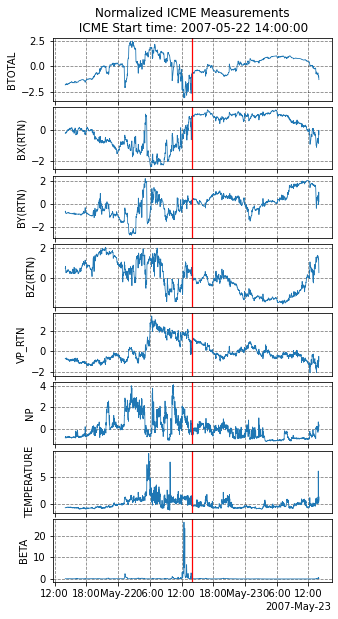

In [72]:
fig = quality_check_plot(sta_data_cut_df, sta_icme_df.index[1], window_size=dt.timedelta(days=1), cols=cols_of_interest, normalize=True)

In [ ]:
sta_data_cut_df['2014'].plot(y='BTOTAL')

In [39]:
sta_data_cut_detrend_df = sta_data_cut_df - sta_data_cut_df.rolling('1D', center=True).mean()

In [ ]:
errors = []
with PdfPages('icmes_stereoA_4day_window_detrended.pdf', 'w') as pdf:
    for date in tqdm(sta_icme_df.index):
        try:
            fig = quality_check_plot(
                sta_data_cut_detrend_df, 
                date, 
                window_size=dt.timedelta(days=2), 
                cols=cols_of_interest,
                normalize=False
            )
        except Exception as e:
            print(e)
            errors.append(date)
        else:
            pdf.savefig(fig)
            plt.close(fig)

In [ ]:
sta_data_cut_detrend_df.index[0].strftime('%Y-%m-%d_%H:%M:%S')

In [ ]:
sta_data_cut_detrend_df.index[0].strftime

In [ ]:
def check_sampling_freq(mag_df, min_sep=None, verbose=False):
    """Determine the sampling frequency from the data

    Compute a weighted-average of the sampling frequency
    present in the time-series data. This is done by taking
    the rolling difference between consecutive datetime indices
    and then binning them up using a method of pd.Series objects.
    Also computes some statistics describing the distribution of
    sampling frequencies.

    Parameters
    ----------
    mag_df : pd.DataFrame
        Pandas dataframe containing the magnetometer data

    min_sep : float
        Minimum separation between two consecutive observations 
        to be consider usable for discontinuity identification

    verbose : boolean
        Specifies information on diverging sampling frequencies
    
    Returns
    -------
    avg_sampling_freq : float
        Weighted average of the sampling frequencies in the dataset

    stats : dict
        Some descriptive statistics for the interval
    
    """
    # Boolean flag for quality of data in interval
    # Assume its not bad and set to True if it is
    bad = False

    # Compute the time difference between consecutive measurements
    # a_i - a_{i-1} and save the data as dt.timedelta objects
    # rounded to the nearest milisecond
    diff_dt = mag_df.index.to_series().diff(1).round('ms')
    sampling_freqs = diff_dt.value_counts()
    sampling_freqs /= sampling_freqs.sum()

    avg_sampling_freq = 0
    for t, percentage in sampling_freqs.items():
        avg_sampling_freq += t.total_seconds() * percentage

    # Compute the difference in units of seconds so we can compute the RMS
    diff_s = np.array(
                list(
                    map(lambda val: val.total_seconds(), diff_dt)
                )
            )

    # Compute the RMS of the observation times to look for gaps in 
    # in the observation period
    t_rms = np.sqrt(
                np.nanmean(
                    np.square(diff_s)
                )
            )
    # flag that the gaps larger the min_sep. 
    if min_sep is None:
        min_sep = 5 * t_rms

    gap_indices = np.where(diff_s > min_sep)[0]
    n_gaps = len(gap_indices)
    
    try:
        previous_indices = gap_indices - 1
    except TypeError as e:
#         LOG.warning(e)
        print(e)
        total_missing = 0
    else:
        interval_durations = mag_df.index[gap_indices] \
                                - mag_df.index[previous_indices]
        total_missing = sum(interval_durations.total_seconds())

    # Compute the duration of the entire interval and determine the coverage
    total_duration = (mag_df.index[-1] - mag_df.index[0]).total_seconds()
    coverage = 1 - total_missing / total_duration

    if verbose and coverage < 0.5:
        msg = (
            f"\n Observational coverage: {coverage:0.2%}\n"
            f"Number of data gaps: {n_gaps:0.0f}\n"
            f"Average sampling rate: {avg_sampling_freq:0.5f}"
            )
#         LOG.warning(msg)
        print(msg)
        bad = True

    stats_data = {}
    stats_data['average_freq'] = avg_sampling_freq
    stats_data['max_freq'] = sampling_freqs.index.max().total_seconds()
    stats_data['min_freq'] = sampling_freqs.index.min().total_seconds()
    stats_data['n_gaps'] = len(gap_indices)
    stats_data['starttime_gaps'] = [mag_df.index[previous_indices]]
    stats_data['total_missing'] = total_missing
    stats_data['coverage'] = coverage

    return avg_sampling_freq, stats_data, bad

In [ ]:
sta_data_cut_df.head()

In [ ]:
check_sampling_freq(sta_data_cut_df, min_sep=120)

### STEREO B dataset

In [ ]:
cols_of_interest = [
    'BTOTAL', 
    'BX(RTN)',
    'BY(RTN)',
    'BZ(RTN)', 
    'VP_RTN',
    'TEMPERATURE',
    'BETA',
    'Np'
]

In [ ]:
def read_stereo_datasets(fname):
    with open(fname, 'r') as fobj:
        lines = fobj.readlines()

    colnames = lines[0].split()
    tmp = lines[1].split()
    units = []
    units.append(' '.join(tmp[:2]))
    units += tmp[2:]

    for col, unit in zip(colnames, units):
        print(col, unit)
        
    data = []
    index = []
    for line in tqdm(lines[2:]):
        lsplit = line.split()
        index.append(dt.datetime.strptime(' '.join(lsplit[:2]), '%d-%m-%Y %H:%M:%S.%f'))
        data.append(list(map(float, lsplit[2:])))
    
    df = pd.DataFrame(data, columns=colnames[1:], index=pd.DatetimeIndex(index))
    return df

In [ ]:
stb_data_df = read_stereo_datasets('../data/stb_l2_magplasma.txt')

In [ ]:
stb_data_df.head()

In [ ]:
stb_data_cut_df = stb_data_df[stb_data_df.gt(-1e30)]

In [ ]:
stb_data_cut_df.info()

In [ ]:
stb_data_cut_df = stb_data_cut_df.dropna()

In [ ]:
stb_data_cut_df.info()

In [ ]:
stb_data_cut_detrend_df = stb_data_cut_df - stb_data_cut_df.rolling('1D', center=True).mean()

In [ ]:
errors = []
with PdfPages('icmes_stereoB_4day_window_detrended.pdf', 'w') as pdf:
    for date in tqdm(stb_icme_df.index):
        try:
            fig = quality_check_plot(
                stb_data_cut_detrend_df, 
                date, 
                window_size=dt.timedelta(days=2), 
                cols=cols_of_interest,
                normalize=False
            )
        except Exception as e:
            print(e)
            errors.append(date)
        else:
            pdf.savefig(fig)
            plt.close(fig)

## Wind dataset

In [ ]:
wind_icme_df = df[df['SC_INSITU'].str.contains('Wind')]

In [ ]:
wind_data_df = pd.read_parquet('/Users/ndmiles/Downloads/datasetWithSpectro.parquet')

In [ ]:
cols_of_interest = ['B','Bx','By','Bz', 'Np', 'V']

In [ ]:
wind_data_df.info()

In [ ]:
wind_icme_df.index = pd.DatetimeIndex(wind_icme_df['ICME_START_TIME'])

In [ ]:
errors = []
with PdfPages('icmes_wind_4day_window.pdf', 'w') as pdf:
    for date in tqdm(wind_icme_df.index):
        try:
            fig = quality_check_plot(
                wind_data_df, 
                date, 
                window_size=dt.timedelta(days=2), 
                cols=cols_of_interest,
                normalize=False
            )
        except Exception as e:
            print(e)
            errors.append(date)
        else:
            pdf.savefig(fig)
            plt.close(fig)